In [11]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

# use GPU for computations if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# temporarily patch this script until the MNIST data set download issue is resolved
# https://github.com/pytorch/vision/issues/1938
import urllib.request
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

# Classification of hand-written digits

We start by downloading and extracting the MNIST data set.

In [12]:
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transforms.ToTensor())

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transforms.ToTensor())

# extract a complete PyTorch dataset
def extract(dataset):
    datasize = len(dataset)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=datasize, shuffle=False)
    return next(iter(dataloader))

# extract all test images and labels into PyTorch tensors
# the training data will be loaded in batches during training
test_X, test_Y = extract(testset)

## The model

The input data $X$ are grayscale images of $28\times 28$ pixels. The first dimension will be the number of data points that are provided to the network. The input data is flattend into a matrix with $28 \times 28 = 784$ columns using `X.view(-1, 784)`, where each colum represents one pixel. We then apply first the linear transformation $X W + b$ and then the softmax function to obtain the class probabilities predicted by the model.

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # the weights of dimension (784, 10)
        self.W = nn.Parameter(torch.zeros(784, 10))
        # the offset vector of dimension (10,)
        self.b = nn.Parameter(torch.zeros(10))

    def forward(self, X):
        # flatten the data into a matrix with 28 x 28 = 784 columns
        X = X.view(-1, 784)
        # compute the linear transformation
        Z = X.mm(self.W) + self.b
        # apply the softmax function
        G = F.softmax(Z, dim=1)
        return G

## The training

We define the cross-entropy for the predicted probabilities $G$ (10-dimensional vectors) and the labels $Y$ (integers between 0 and 9).

In [14]:
def crossentropy(G, Y):
    # convert labels to onehot encoding
    Y_onehot = torch.eye(10, device=device)[Y]

    return -(Y_onehot * G.log()).sum(dim = 1).mean()

The next lines evaluate the accuracy of the predictions.

In [15]:
def accuracy(G, Y):
    return (G.argmax(dim=1) == Y).float().mean()

We are ready to train the network.

In [16]:
# initialize the test and training error statistics
test_accuracy = []
test_crossentropy = []
test_iter = []
train_accuracy = []
train_crossentropy = []
train_iter = []

# initialize the neural network and move it to the GPU if needed
net = Net()
net.to(device)

# define the optimization algorithm
learningrate = 0.5
optimizer = optim.SGD(net.parameters(), lr=learningrate)

# define the data loader for batches of the training data
batchsize = 100
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, num_workers=2, shuffle=True)

# perform multiple training steps
total_iterations = 2000 # total number of iterations
t = 0 # current iteration
done = False
while not done:
    for (batch_X, batch_Y) in trainloader:
        # move batch to the GPU if needed
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass
        batch_G = net(batch_X)
        loss = crossentropy(batch_G, batch_Y)

        # backpropagation
        loss.backward()

        # perform gradient descent step
        optimizer.step()

        # don't bother too much about the following lines!
        with torch.no_grad():
            # evaluate the performance on the training data at every 10th iteration
            if t % 10 == 0:
                train_crossentropy.append(loss.item())
                train_accuracy.append(accuracy(batch_G, batch_Y).item())
                train_iter.append(t)

            # evaluate the performance on the test data at every 100th iteration
            if t % 100 == 0:
                # move test data to the GPU if needed
                X, Y = test_X.to(device), test_Y.to(device)

                # compute predictions for the test data
                G = net(X)
                test_crossentropy.append(crossentropy(G, Y).item())
                test_accuracy.append(accuracy(G, Y).item())
                test_iter.append(t)

                # print the iteration number and the accuracy of the predictions
                print(f"Step {t:5d}: train accuracy {100 * train_accuracy[-1]:6.2f}% " \
                      f"train cross-entropy {train_crossentropy[-1]:5.2f}  " \
                      f"test accuracy {100 * test_accuracy[-1]:6.2f}% " \
                      f"test cross-entropy {test_crossentropy[-1]:5.2f}")

        # stop the training after the specified number of iterations
        t += 1
        if t > total_iterations:
            done = True
            break

Step     0: train accuracy   8.00% train cross-entropy  2.30  test accuracy  29.40% test cross-entropy  2.01
Step   100: train accuracy  87.00% train cross-entropy  0.46  test accuracy  88.51% test cross-entropy  0.41
Step   200: train accuracy  94.00% train cross-entropy  0.36  test accuracy  90.48% test cross-entropy  0.34
Step   300: train accuracy  84.00% train cross-entropy  0.43  test accuracy  90.41% test cross-entropy  0.33
Step   400: train accuracy  96.00% train cross-entropy  0.21  test accuracy  91.13% test cross-entropy  0.31
Step   500: train accuracy  90.00% train cross-entropy  0.41  test accuracy  91.16% test cross-entropy  0.31
Step   600: train accuracy  91.00% train cross-entropy  0.34  test accuracy  91.51% test cross-entropy  0.30
Step   700: train accuracy  92.00% train cross-entropy  0.44  test accuracy  91.72% test cross-entropy  0.30
Step   800: train accuracy  91.00% train cross-entropy  0.26  test accuracy  91.53% test cross-entropy  0.30
Step   900: train a

## The evaluation

The remaining code produces the plots needed to evaluate the training and predictions.

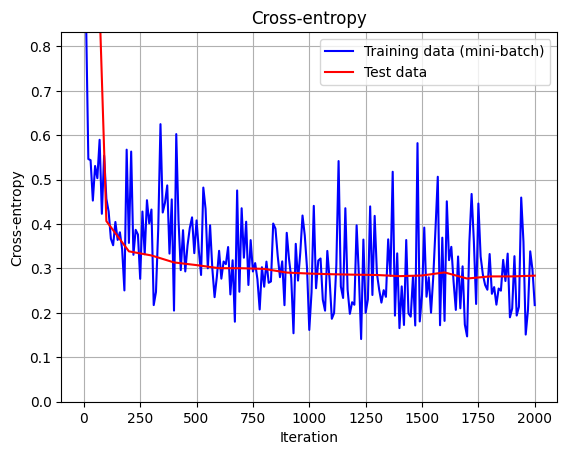

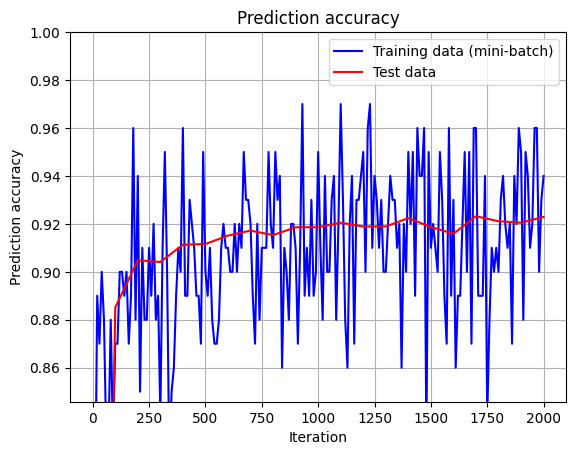

In [17]:
# plot the cross-entropy
plt.plot(train_iter, train_crossentropy, 'b-', label='Training data (mini-batch)')
plt.plot(test_iter, test_crossentropy, 'r-', label='Test data')
plt.xlabel('Iteration')
plt.ylabel('Cross-entropy')
plt.ylim([0, min(test_crossentropy) * 3])
plt.title('Cross-entropy')
plt.grid(True)
plt.legend(loc='best')
plt.show()

# plot the accuracy
plt.plot(train_iter, train_accuracy, 'b-', label='Training data (mini-batch)')
plt.plot(test_iter, test_accuracy, 'r-', label='Test data')
plt.xlabel('Iteration')
plt.ylabel('Prediction accuracy')
plt.ylim([max(1 - (1 - test_accuracy[-1]) * 2, 0), 1])
plt.title('Prediction accuracy')
plt.grid(True)
plt.legend(loc='best')
plt.show()

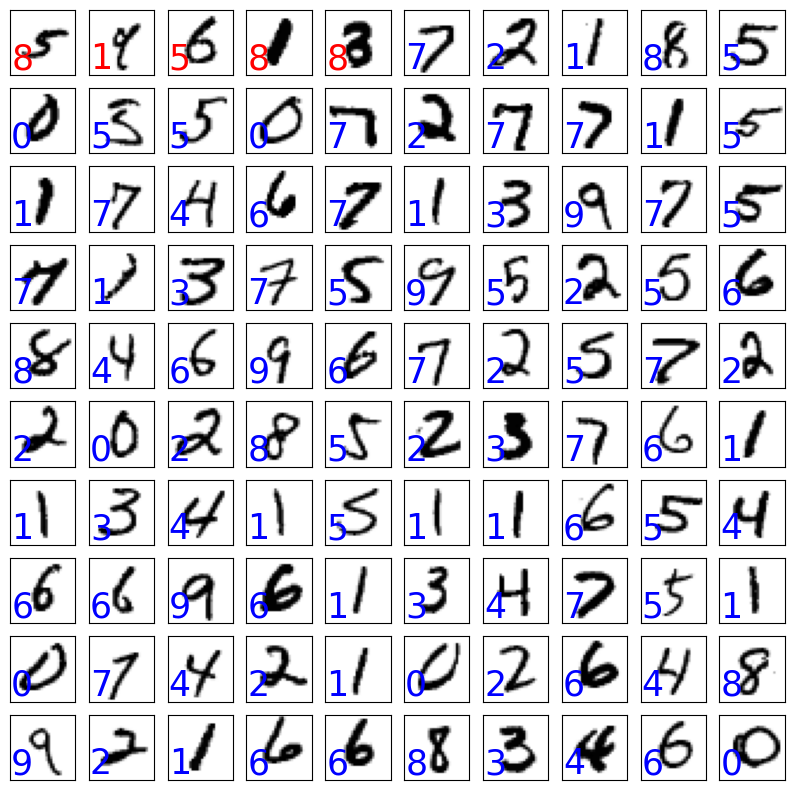

In [18]:
# evaluate the network on 100 random test images
with torch.no_grad():
    # obtain 100 random samples from the test data set
    random_X, random_Y = next(iter(torch.utils.data.DataLoader(testset, batch_size=100, shuffle=True)))

    # move data to the GPU if needed
    random_X, random_Y = random_X.to(device), random_Y.to(device)

    # compute the predictions for the sampled inputs
    random_G = net(random_X)
    random_Yhat = random_G.argmax(dim=1)

    # sort the predictions with the incorrect ones first
    indices_incorrect_first = (random_Yhat == random_Y).float().argsort()

# plot the images
num_rows = 10
num_cols = 10
num_images = num_rows * num_cols
plt.figure(figsize=(num_cols, num_rows))

for i, index in enumerate(indices_incorrect_first, 1):
    plt.subplot(num_rows, num_cols, i)
    plt.xticks([])
    plt.yticks([])

    # plot the image
    plt.imshow(random_X[index, :, :].view(28, 28).cpu().numpy(), cmap=plt.cm.binary)

    # add the prediction as annotation (incorrect predictions in red, correct ones in blue)
    color = 'blue' if random_Yhat[index] == random_Y[index] else 'red'
    plt.text(0, 25, random_Yhat[index].item(), fontsize=25, color=color)

plt.show()

In [19]:
# --- TASK 4.4: Two-Layer Network with Sigmoid ---
print("\n--- STARTING TASK 4.4 (Two Layers) ---")

# 1. Define the 2-Layer Model
class TwoLayerNet(nn.Module):
    def __init__(self):
        super(TwoLayerNet, self).__init__()
        self.fc1 = nn.Linear(784, 200) # Hidden layer
        self.fc2 = nn.Linear(200, 10)  # Output layer

    def forward(self, x):
        x = x.view(-1, 784)
        x = torch.sigmoid(self.fc1(x)) # Sigmoid activation (Task 4.4 Requirement)
        x = self.fc2(x)
        return x

# 2. Train it
net2 = TwoLayerNet().to(device)
optimizer = optim.SGD(net2.parameters(), lr=0.5)
criterion = nn.CrossEntropyLoss()

print("Training Task 4.4 Model ...")

# We run for 5 Epochs (Passes through the data)
for epoch in range(5):
    net2.train()
    for batch_X, batch_Y in trainloader:
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
        optimizer.zero_grad()
        output = net2(batch_X)
        loss = criterion(output, batch_Y)
        loss.backward()
        optimizer.step()

    # Check accuracy at the end of every epoch
    net2.eval()
    correct = 0
    with torch.no_grad():
        X, Y = test_X.to(device), test_Y.to(device)
        pred = net2(X).argmax(dim=1)
        correct += pred.eq(Y).sum().item()
    print(f"Epoch {epoch+1}: Accuracy = {100. * correct / len(test_Y):.2f}%")


--- STARTING TASK 4.4 (Two Layers) ---
Training Task 4.4 Model ...
Epoch 1: Accuracy = 91.22%
Epoch 2: Accuracy = 92.89%
Epoch 3: Accuracy = 93.95%
Epoch 4: Accuracy = 94.80%
Epoch 5: Accuracy = 95.34%


In [20]:
# --- TASK 4.9: The Final CNN (Mandatory) ---
print("\n--- STARTING TASK 4.9 (CNN) ---")

# 1. Define the CNN Architecture (Table 1)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Layer 1: 5x5 filter, Stride 1, Padding 2
        self.conv1 = nn.Conv2d(1, 4, 5, stride=1, padding=2)
        # Layer 2: 5x5 filter, Stride 2, Padding 2
        self.conv2 = nn.Conv2d(4, 8, 5, stride=2, padding=2)
        # Layer 3: 4x4 filter, Stride 2, Padding 1
        self.conv3 = nn.Conv2d(8, 12, 4, stride=2, padding=1)

        # Flatten size: 12 channels * 7 * 7 = 588
        self.flatten_dim = 12 * 7 * 7

        self.fc1 = nn.Linear(self.flatten_dim, 200)
        self.fc2 = nn.Linear(200, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(-1, self.flatten_dim)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 2. Train using Adam (Task 4.6 requirement)
cnn = CNN().to(device)
optimizer = optim.Adam(cnn.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss() # Task 4.8 requirement

print("Training CNN ...")

# Train for 10 Epochs (Task 4.7 requirement)
for epoch in range(10):
    cnn.train()
    for batch_X, batch_Y in trainloader:
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
        optimizer.zero_grad()
        output = cnn(batch_X)
        loss = criterion(output, batch_Y)
        loss.backward()
        optimizer.step()

    # Check accuracy
    cnn.eval()
    correct = 0
    with torch.no_grad():
        X, Y = test_X.to(device), test_Y.to(device)
        pred = cnn(X).argmax(dim=1)
        correct += pred.eq(Y).sum().item()
    print(f"Epoch {epoch+1}: Accuracy = {100. * correct / len(test_Y):.2f}%")


--- STARTING TASK 4.9 (CNN) ---
Training CNN ...
Epoch 1: Accuracy = 97.36%
Epoch 2: Accuracy = 98.30%
Epoch 3: Accuracy = 98.72%
Epoch 4: Accuracy = 98.42%
Epoch 5: Accuracy = 98.56%
Epoch 6: Accuracy = 99.06%
Epoch 7: Accuracy = 98.75%
Epoch 8: Accuracy = 98.94%
Epoch 9: Accuracy = 98.56%
Epoch 10: Accuracy = 98.59%
